&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../../Start_Here.ipynb)

[Previous Notebook](../diffusion_1d/Diffusion_Problem_Notebook.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[1](../introduction/Introductory_Notebook.ipynb)
[2](../diffusion_1d/Diffusion_Problem_Notebook.ipynb)
[3]
[4](../chip_2d/Challenge_CFD_Problem_Notebook.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](../chip_2d/Challenge_CFD_Problem_Notebook.ipynb)

# Solving Ordinary Differential Equations using PINNs

Now that we have familirized ourself with the Modulus APIs and solved the 1-dimensional diffusion equation in a single simulation and parameterized setting, we move to the next application of PINNs. In this notebook we will solve the system of differential equations that define a coupled spring mass porblem. In this tutorial we will see how to solve the transient problems over small time intervals easily by treating time as a continuous variable. We will also use PINNs to solve the problem in an inverse setting where we have the solution data and we use PINN to find the coefficient of the ODE.

You can refer to the *Modulus User Guide Chapter 4 and Chpater 12* for more examples on solving different types of time domain problems and inverse problems respectively. Also, for more information about the Modulus APIs you can refer the *Modulus Source Code Documentation*. 

### Learning Outcomes
1. How to use Modulus to simulate transient problems using PINNs by treating time as a continuous variable
2. How to use Modulus to solve a inverse problem
    

## Problem Description

In this tutorial, we will solve a simple spring mass system as shown in figure below. The systems shows three masses attached to each other by four springs. The springs slide along a friction-less horizontal surface. The masses are assumed to be point masses and the springs are mass-less.

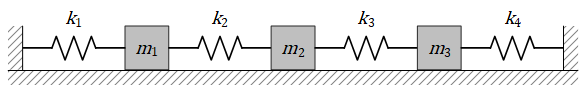

The model's equations are given as below:
$$
\begin{equation}\label{ode_eqn}
\begin{split}
m_1 x_1''(t) &= -k_1 x_1(t) + k_2(x_2(t) - x_1(t)),\\
m_2 x_2''(t) &= -k_2 (x_2(t) - x_1(t))+ k_3(x_3(t) - x_2(t)),\\
m_3 x_3''(t) &= -k_3 (x_3(t) - x_2(t)) - k_4 x_3(t). \end{split}
\end{equation}
$$

Where, $x_1(t), x_2(t), \text{and } x_3(t)$ denote the mass positions along the horizontal surface measured from their equilibrium position, plus right and minus left. As shown in the figure, first and the last spring are fixed to the walls. 

For the first part of the tutorial, we will assume the following conditions:
$$
\begin{equation}\label{ode_IC}
\begin{split}
[m_1, m_2, m_3] &= [1, 1, 1],\\
[k_1, k_2, k_3, k_4] &= [2, 1, 1, 2],\\
[x_1(0), x_2(0), x_3(0)] &= [1, 0, 0],\\
[x_1'(0), x_2'(0), x_3'(0)] &= [0, 0, 0].
\end{split}
\end{equation}
$$

## Case Setup

Now that we have our problem defined, let's take a look at the code required to solve it using Modulus. 

## Defining the differential equations for the problem

This process is similar to the previous tutorial. We will write each parameter ($k's \text{ and } m's$) as function and substitute it as a number if its constant. This will allow usto parameterize any of this constants by passing them as a string. This will also allow us to solve the inverse problem where either of these quantitity is unknown and can be predicted by the neural network. 

In [ ]:
from sympy import Symbol, Function, Number
from modulus.pdes import PDES
from modulus.variables import Variables

class SpringMass(PDES):
  name= 'SpringMass'

  def __init__(self, k=(2, 1, 1, 2), m=(1, 1, 1)):
    
    self.k  = k
    self.m  = m

    k1 = k[0]
    k2 = k[1]
    k3 = k[2]
    k4 = k[3]
    m1 = m[0]
    m2 = m[1]
    m3 = m[2]

    t=Symbol('t')
    input_variables = {'t':t}
    
    x1 = Function('x1')(*input_variables)
    x2 = Function('x2')(*input_variables)
    x3 = Function('x3')(*input_variables)

    if type(k1) is str:
        k1 = Function(k1)(*input_variables)
    elif type(k1) in [float, int]:
        k1 = Number(k1)
    if type(k2) is str:
        k2 = Function(k2)(*input_variables)
    elif type(k2) in [float, int]:
        k2 = Number(k2)
    if type(k3) is str:
        k3 = Function(k3)(*input_variables)
    elif type(k3) in [float, int]:
        k3 = Number(k3)
    if type(k4) is str:
        k4 = Function(k4)(*input_variables)
    elif type(k4) in [float, int]:
        k4 = Number(k4)

    if type(m1) is str:
        m1 = Function(m1)(*input_variables)
    elif type(m1) in [float, int]:
        m1 = Number(m1)
    if type(m2) is str:
        m2 = Function(m2)(*input_variables)
    elif type(m2) in [float, int]:
        m2 = Number(m2)
    if type(m3) is str:
        m3 = Function(m3)(*input_variables)
    elif type(m3) in [float, int]:
        m3 = Number(m3)

    self.equations = Variables()
    self.equations['ode_x1'] = m1*(x1.diff(t)).diff(t) + k1*x1 - k2*(x2 - x1)
    self.equations['ode_x2'] = m2*(x2.diff(t)).diff(t) + k2*(x2 - x1) - k3*(x3 - x2)
    self.equations['ode_x3'] = m3*(x3.diff(t)).diff(t) + k3*(x3 - x2) + k4*x3

## Creating the geometry

Once we have the ODEs defined, we can easily form the train domain as seen in earlier tutorials. In this example, we will use `Point1D` geometry to create the point mass. We will also define the time range of the solution and create symbol for time ($t$) to define the initial condition etc. in train domain. The below code shows the geometry definition for this problem. The strategy of solving transient problem using time as a continuous variable is same as solving a parameterized problem, i.e. we will create a symbolic variable for time `t` and use the time range as an input to the `param_ranges` attribute for the boundary and interior sampling

In [ ]:
from sympy import Symbol, Eq
import numpy as np
from modulus.solver import Solver
from modulus.dataset import TrainDomain, ValidationDomain
from modulus.data import Validation
from modulus.sympy_utils.geometry_1d import Point1D
from modulus.controller import ModulusController
from modulus.plot_utils.vtk import var_to_vtk

import os
import sys

sys.path.append('../../source_code/spring_mass')

from spring_mass_ode import SpringMass

# define time variable and range
t_max = 10.0
t_symbol = Symbol('t')
x = Symbol('x')
time_range = {t_symbol: (0, t_max)}

geo = Point1D(0)

## Creating Train Domain: Assigning the initial conditions and equations

Next, we will define the train domain using the 1d point we just defined. Please note that we would not be using the x-coordinate ($x$) information of the point, and it is only used to sample a point in space. We will assign it different values for variable ($t$) only (initial conditions and ODEs over the time-range). 

In [ ]:
class SpringMassTrain(TrainDomain):
  def __init__(self, **config):
    super(SpringMassTrain, self).__init__()

    # initial conditions
    IC = geo.boundary_bc(outvar_sympy={'x1': 1.,
                                       'x2': 0,
                                       'x3': 0,
                                       'x1__t': 0,
                                       'x2__t': 0,
                                       'x3__t': 0},
                         param_ranges={t_symbol: 0},
                         batch_size_per_area=1)
    self.add(IC, name="IC")

    # solve over given time period
    interior = geo.boundary_bc(outvar_sympy={'ode_x1': 0.0,
                                             'ode_x2': 0.0,
                                             'ode_x3': 0.0}, 
                               param_ranges=time_range,
                               batch_size_per_area=500)
    self.add(interior, name="Interior")

## Creating Validation Domain

Next we will define the validation data for this problem. The solution of this problem can be obtained analytically and the expression can be coded into dictionaries of numpy arrays for `x1`, `x2`, and `x3`. This part of the code is similar to the previous diffusion example.

In [ ]:
class SpringMassVal(ValidationDomain):
   def __init__(self, **config):
     super(SpringMassVal, self).__init__()
     deltaT = 0.001
     t = np.arange(0, t_max, deltaT)
     t = np.expand_dims(t, axis=-1) 
     invar_numpy = {'t': t}
     outvar_numpy = {'x1': (1/6)*np.cos(t) + (1/2)*np.cos(np.sqrt(3)*t) + (1/3)*np.cos(2*t),
                     'x2': (2/6)*np.cos(t) + (0/2)*np.cos(np.sqrt(3)*t) - (1/3)*np.cos(2*t),
                     'x3': (1/6)*np.cos(t) - (1/2)*np.cos(np.sqrt(3)*t) + (1/3)*np.cos(2*t)} 
     val = Validation.from_numpy(invar_numpy, outvar_numpy)
     self.add(val, name="Val")

## Creating the Neural Network Solver

Now that we have the train domain and other validation and monitor domains defined, we can prepare the neural network solver and run the problem. We can see that since this is problem involves only time dimension, we will creat the network with only `t` as input. 

In [ ]:
class SpringMassSolver(Solver):
  train_domain = SpringMassTrain
  val_domain = SpringMassVal

  def __init__(self, **config):
    super(SpringMassSolver, self).__init__(**config)

    self.equations = SpringMass(k=(2, 1, 1, 2), m=(1, 1, 1)).make_node()

    spring_net = self.arch.make_node(name='spring_net',
                                   inputs=['t'],
                                   outputs=['x1','x2','x3'])
    self.nets = [spring_net]

  @classmethod # Explain This
  def update_defaults(cls, defaults):
    defaults.update({
        'network_dir': './network_checkpoint_spring_mass',
        'max_steps': 10000,
        'decay_steps': 100,
        'nr_layers': 6,
        'layer_size': 256,
        'xla': True,
        })

Awesome! We have just completed the file set up for the problem. We are now ready to solve the sytem of ODEs using Neural Networks!

In [ ]:
import os
import sys

sys.path.append('../../source_code/spring_mass')
!python ../../source_code/spring_mass/spring_mass_solver.py 

## Visualizing the solution

The .npz arrays can be plotted to visualize the output of the simulation. The .npz files that are created are found in the `network_checkpoint*` directory. The below figure shows the comparison of the neural network solution and the analytical solution. Again, we have a very good agreement in both the results. 

<img src="comparison.png" alt="Drawing" style="width: 500px;"/>

The below script shows an example of how the npz arrays can be plotted. 

In [ ]:
%%capture
import sys
!{sys.executable} -m pip install ipympl
%matplotlib inline
import matplotlib.pyplot as plt

base_dir = './network_checkpoint_spring_mass/val_domain/results/'
# plot in 1d
predicted_data = np.load(base_dir + 'Val_pred.npz', allow_pickle=True)
true_data = np.load(base_dir + 'Val_true.npz', allow_pickle=True)
predicted_data = np.atleast_1d(predicted_data.f.arr_0)[0]
true_data = np.atleast_1d(true_data.f.arr_0)[0]

plt.plot(true_data['t'], true_data['x1'], label='True x1')
plt.plot(true_data['t'], true_data['x2'], label='True x2')
plt.plot(true_data['t'], true_data['x3'], label='True x3')
plt.plot(predicted_data['t'], predicted_data['x1'], label='Pred x1')
plt.plot(predicted_data['t'], predicted_data['x2'], label='Pred x2')
plt.plot(predicted_data['t'], predicted_data['x3'], label='Pred x3')
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend()
plt.savefig('comparison_spring_mass.png')

In [ ]:
from IPython.display import Image
Image(filename='comparison_spring_mass.png') 

# Solving the Inverse Problem

Another important advantage of a neural network solver over traditional numerical methods is its ability to solve inverse problems. In an inverse problem, we start with a set of observations and then use those observations to calculate the causal factors that produced them. To demonstrate this concept we will solve the same spring mass system in an inverse setting. Specifically, we will assume that the data for the displacements of the 3 masses $x_1, x_2 \text{ and } x_3$ is available to us through analytical solution and the first mass ($m_1$) and the last spring coefficient ($k_4$) is unknown. We will use the neural network to assimilate the displacements from the analytical solution and use it to invert out the unknown quantites from ODEs.

## Case Setup

The equation file again remains same for this part. Here, we will use the `BC` class to assimilate the solution in the training data. Then we will make a network to memorize the three displacements by developing a mapping between $t$ and $(x_1, x_2, x_3)$. The second network will be trained to invert out the desired quantites viz. $(m_1, k_4)$. 

## Creating Train Domain

For this problem, we will use the solution coming from analytical solution in from of numpy arrays. We will use the `BC` class to handle such input data. The `BC` class takes in separate dictionaries for input variables and output variables. These dictionaries have a key for each variable and a numpy array of values associated to the key. The `BC` class can be used to assimilate more data even in the forms of a text, CSV, etc. file formats. All we need to do is to convert them into pairs of key and variable and form a dictionary. The `BC` class is very versatile and forms the parent class for the `interior_bc` and `boundary_bc` methods that we have used in the previous tutorials. More information on how to use the `BC` class can be found in the *Modulus User Guide Chapter 12*.

Since part of the problem involves memorizing the given flow field, we will have `['t']` as input keys and `['x_1', 'x_2', 'x_3', 'ode_x1', 'ode_x2', 'ode_x3']` as the output keys. Setting `['x_1', 'x_2', 'x_3']` as input values from analytical data, we are essentially making the network assimilate the analytical distribution of these variables in the selected domain. Setting `['ode_x1', 'ode_x2', 'ode_x3']` equal to 0, we also inform the network to satisfy the ODE losses at those sampled points. Now assuming that we also know the initial conditions of the solution, except the `'m_1'` and `'k_4'`, all the variables in these ODEs are known. Thus the network can use this information to invert out the unknowns. Lets only look at the major additions/changes to the code. The full script can be referred in `spring_mass_inverse.py`. 

In [ ]:
# define time variable and range
t_max = 10.0
t_symbol = Symbol('t')
x = Symbol('x')
time_range = {t_symbol: (0, t_max)}

geo = Point1D(0)

deltaT = 0.01
t = np.arange(0, t_max, deltaT)
t = np.expand_dims(t, axis=-1) 

invar_numpy = {'t': t}
outvar_numpy = {'x1': (1/6)*np.cos(t) + (1/2)*np.cos(np.sqrt(3)*t) + (1/3)*np.cos(2*t),
                'x2': (2/6)*np.cos(t) + (0/2)*np.cos(np.sqrt(3)*t) - (1/3)*np.cos(2*t),
                'x3': (1/6)*np.cos(t) - (1/2)*np.cos(np.sqrt(3)*t) + (1/3)*np.cos(2*t)} 
outvar_numpy.update({'ode_x1': np.full_like(invar_numpy['t'], 0)})
outvar_numpy.update({'ode_x2': np.full_like(invar_numpy['t'], 0)})
outvar_numpy.update({'ode_x3': np.full_like(invar_numpy['t'], 0)})

class SpringMassTrain(TrainDomain):
  def __init__(self, **config):
    super(SpringMassTrain, self).__init__()

    # initial conditions
    IC = geo.boundary_bc(outvar_sympy={'x1': 1.,
                                       'x2': 0,
                                       'x3': 0,
                                       'x1__t': 0,
                                       'x2__t': 0,
                                       'x3__t': 0},
                         param_ranges={t_symbol: 0},
                         batch_size_per_area=1)
    self.add(IC, name="IC")

    # data
    data =  BC.from_numpy(invar_numpy, outvar_numpy)

    self.add(data, name="Data")

## Creating Monitor Domain

For this tutorial, we will create `MonitorDomain` to monitor the convergence of average `'m_1'` and `'k_4'` inside the domain as the solution progresses. Once we find that the average value of these quantities have reached a steady value, we can end the simulation. The code to generate the `MonitorDomain` can be found below

In [ ]:
from modulus.dataset import MonitorDomain
class SpringMassMonitor(MonitorDomain):
  def __init__(self, **config):
    super(SpringMassMonitor, self).__init__()
    
    global_monitor = Monitor(invar_numpy, {'average_m1': lambda var: tf.reduce_mean(var['m1']),
                                           'average_k4': lambda var: tf.reduce_mean(var['k4'])})
    self.add(global_monitor, 'GlobalMonitor')

## Creating the Neural Network Solver

The process of creating a neural network for an inverse problem is similar to other problems we have seen in previous tutorials. However, as the information for the displacements, and in turn their gradients (i.e. velocities and accelerations), is already present (from analytical data) for the network to memorize, we will stop the gradient calls on each of these variables in their respective equations. This means that only the networks predicting `'m1'` and `'k4'` will be optimized to minimize the equation residuals. The displacements, velocities and accelerations are treated as ground truth data.

Also, note that the the mass and spring constant are passed in as Symbolic variables (`'m1'` and `'k4'` respectively) to the
equations as they are unknowns in this problem.

In [ ]:
class SpringMassSolver(Solver):
  train_domain = SpringMassTrain
  monitor_domain = SpringMassMonitor

  def __init__(self, **config):
    super(SpringMassSolver, self).__init__(**config)

    self.equations = SpringMass(k=(2, 1, 1, 'k4'), m=('m1', 1, 1)).make_node(stop_gradients=['x1', 'x1__t', 'x1__t__t',
                                                                                             'x2', 'x2__t', 'x2__t__t',
                                                                                             'x3', 'x3__t', 'x3__t__t'])

    spring_net = self.arch.make_node(name='spring_net',
                                   inputs=['t'],
                                   outputs=['x1','x2','x3'])
    invert_net = self.arch.make_node(name='invert_net',
                                   inputs=['t'],
                                   outputs=['m1','k4'])

    self.nets = [spring_net, invert_net]

  @classmethod # Explain This
  def update_defaults(cls, defaults):
    defaults.update({
        'network_dir': './network_checkpoint_spring_mass_inverse',
        'max_steps': 10000,
        'decay_steps': 100,
        'nr_layers': 6,
        'layer_size': 256,
        'xla': True,
        })

## Visualizing the solution

We can monitor the Tensorboard plots to see the convergence of the simulation and the final values of the $m_1$ and $k_4$. We see that after sufficient training, we get the $m_1$ and $k_4$ as 1 and 2 respectively. These were the same values that we used to create the analytical solution.


# Licensing
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0)


&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../../Start_Here.ipynb)

[Previous Notebook](../diffusion_1d/Diffusion_Problem_Notebook.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[1](../introduction/Introductory_Notebook.ipynb)
[2](../diffusion_1d/Diffusion_Problem_Notebook.ipynb)
[3]
[4](../chip_2d/Challenge_CFD_Problem_Notebook.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](../chip_2d/Challenge_CFD_Problem_Notebook.ipynb)
